## Taken from https://github.com/zarif101/FakeFace

## Libraries

In [1]:
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPool2D,Input,BatchNormalization,Lambda,Reshape,Conv2DTranspose
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array 
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import warnings
import random as raa
from os import listdir
from os.path import isfile, join
import tensorflow
import imageio
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
import cv2
import os

## Globals

In [2]:
# global variables
latent_dim = 50
decoder = Model

# handle warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Classes

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
        

In [4]:
class VAE(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tensorflow.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tensorflow.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tensorflow.keras.metrics.Mean(name="kl_loss")
 
    @property
    def metrics(self):
        return [self.total_loss_tracker,self.reconstruction_loss_tracker,self.kl_loss_tracker]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean,z_log_var,z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data,reconstruction), axis=(1,2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }        

## Driving function

In [5]:
def fakeface(button):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Virtual devices must be set before GPUs have been initialized
            print(e)

    source_path = 'jpeg'
    img_files = [f for f in listdir(source_path) if isfile(join(source_path, f))]

    x_imgs = []
    for file in img_files:
        if file[0] != '.':
            target_img_path = source_path + '/' + file
            img = load_img(target_img_path)
            img = img_to_array(img)
            # img = cv2.resize(img, (100, 100))  # take out for homework should be 64, 64
            # img = img/255.0 
            x_imgs.append(img / 255.0)

    import matplotlib.pyplot as plt
    plt.imshow(x_imgs[0])
    print(x_imgs[0].shape)

    X = np.array(x_imgs)
    #X.shape

    tensorflow.keras.backend.clear_session()

    encoder_inputs = Input((64, 64, 3))
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(encoder_inputs)
    x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPool2D((2, 2))(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = MaxPool2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(units=128, activation='relu')(x)
    z_mean = Dense(latent_dim, activation='relu', name='zmean')(x)
    z_log_var = Dense(latent_dim, activation='relu', name='zlogvar')(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z])
    #encoder.summary()

    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(64 * 64 * 16, activation="relu")(latent_inputs)
    x = Reshape((64, 64, 16))(x)
    x = Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = Conv2DTranspose(32, 3, activation="relu", padding="same")(x)
    x = Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
    decoder_outputs = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(latent_inputs, decoder_outputs, name="decoder")
    #decoder.summary()
    
    if verbosity.value == True:
        verb = 1
    else:
        verb = 0;
    
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    #verb=1 if verbosity.value==True else verb=0
    vae.fit(X, epochs=iterations.value, verbose=verbosity.value)

    vae.save_weights('face_vae_weights.h5')
    
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    vae.built = True
    vae.load_weights('face_vae_weights.h5')

    # SAVING ARCHITECTURE
    import pickle

    with open('VAE_face.pickle', 'wb') as file:
        pickle.dump(VAE, file)

    ## PREDICTIONS

    r = []
    for i in range(50):
        rand = raa.uniform(-1, 5)
        r.append(rand)
    r = np.array(r)

    r = r.reshape((1, 50))
    random_vectors = np.random.normal(loc=0, scale=1, size=(1, 50))
    random_vectors *= r
    pred = vae.decoder.predict(r)

    plt.imshow(pred[0].reshape((64, 64, 3)))

    existing = X[88]
    pred = vae.encoder.predict(existing.reshape((1, 64, 64, 3)))
    pred = pred[2]
    predd = vae.decoder.predict(pred)

    plt.imshow(predd.reshape((64, 64, 3)))

    plt.imshow(existing.reshape((64, 64, 3)))
    
    decoder.save('saved_model')

    genpoke(button)

In [6]:
def genpoke(button):
    
    decoder = tf.keras.models.load_model('saved_model')
     
    # z_sample = np.array([[-1000.0, 1000.0]])
    z_sample = np.array([np.random.rand(50)])
    #print(z_sample)
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0]  # .resahpe(64, 64)
    plt.imshow(digit, cmap='Greys_r')
    plt.show()


## User Interface

(64, 64, 3)
Epoch 1/50
70/70 [==============================] - 31s 439ms/step - loss: 2755.8477 - reconstruction_loss: 2705.2522 - kl_loss: 7.9112
Epoch 2/50
70/70 [==============================] - 33s 474ms/step - loss: 2651.0319 - reconstruction_loss: 2633.2368 - kl_loss: 9.8457
Epoch 3/50
70/70 [==============================] - 38s 545ms/step - loss: 2632.1182 - reconstruction_loss: 2613.0376 - kl_loss: 12.5784
Epoch 4/50
70/70 [==============================] - 43s 612ms/step - loss: 2612.9434 - reconstruction_loss: 2596.0742 - kl_loss: 13.9232
Epoch 5/50
70/70 [==============================] - 42s 607ms/step - loss: 2596.7991 - reconstruction_loss: 2584.9285 - kl_loss: 15.2062
Epoch 6/50
70/70 [==============================] - 44s 630ms/step - loss: 2600.8440 - reconstruction_loss: 2581.3843 - kl_loss: 15.4876
Epoch 7/50
70/70 [==============================] - 42s 605ms/step - loss: 2588.3112 - reconstruction_loss: 2572.8594 - kl_loss: 15.9144
Epoch 8/50
70/70 [=============

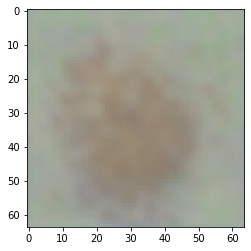

In [7]:
from ipywidgets import widgets
entire = widgets.Button(description='Entire Notebook')
entire.on_click(fakeface)
poke = widgets.Button(description='Another Poke')
poke.on_click(genpoke)
iterations = widgets.IntText(value=4, description='epochs:', disabled=False)
verbosity = widgets.ToggleButton(value=True, description='Display epochs',icon='check')
widgets.HBox([entire, poke, iterations, verbosity])